In this notebook, we do a systematic training of a 2-layer GCN to predict X1 data from a single corresponding X2 value at the same time tnstant in the following manner:
* train on a single data point
* train on 2 data points to ensure we can fit/overfit 
* train on 3 data points 
* ...
* train on 100 data points, at which point we split into train and val sets 
* add more and more data and hopefully it gets better and better at generalizing to unseen data 


We are following the suggestion from this [stackexchange post](https://stats.stackexchange.com/questions/261704/training-a-neural-network-for-regression-always-predicts-the-mean). 

edit: we only train using 2 and 5 samples, because the results are not great and I don't think it's worth going further until we look into it a bit more. 

also: I've reduced the number of nodes to 6 so that we can start with less data and make it easier to overfit. This means that when I say 2 data samples, there are actually 12 total data points, 2 for each node, that need to be predicted. 

### imports and setup

In [100]:
# # google colab setup (comment out this cell if running locally)
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd "/content/drive/My Drive/_research ML AQ/lorenz 96 gnn" # so we can access pre-generated lorenz data
# !pip3 install spektral

In [101]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

# Load the TensorBoard notebook extension
%load_ext tensorboard

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [102]:
# libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from lorenz import lorenzDataset, lorenzDatasetWrapper, DEFAULT_TIME_RESOLUTION
from plotters import plot_data
from tuning import make_train_GCN, make_train_GCN3, plot_model_results
from models import NaiveConstant, NaiveZero

from spektral.data import MixedLoader

from datetime import datetime

In [103]:
# check that GPU is set up
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('no GPU device found')
else:
    print('found GPU at: {}'.format(device_name))
print('num GPUs available:', len(tf.config.list_physical_devices("GPU")))

no GPU device found
num GPUs available: 0


## systematically train the model

### 2 data points 
originally I start with 2 because I wanted >1 data points so the std!=0, which was messing with the normalization function. (At t=0, the initial condition, the X2 variable has no perturbation.) However, I've now added an initial buffer, which should take care of this issue, meaning it should be fine to run with 1 data point. 

#### prepare data

In [104]:
# only uncomment each line if testing a non-default parameter
dataset_2 = lorenzDatasetWrapper(
    predict_from="X2",
    n_samples=2,
    # input_steps=2 * DEFAULT_TIME_RESOLUTION,  # 2 days
    # output_delay=1 * DEFAULT_TIME_RESOLUTION,  # 1 day
    # output_steps=1,
    # min_buffer=-3 * DEFAULT_TIME_RESOLUTION,
    # rand_buffer=False,
    K=6,
    # F=8,
    # c=10,
    # b=10,
    # h=1,
    # coupled=True,
    # time_resolution=DEFAULT_TIME_RESOLUTION,
    # seed=42,
    init_buffer_steps=100,
    return_buffer=True,
    train_pct=
    1,  # no train/val split since we have so few data points and just want to ensure overfitting right now
    val_pct=0,
    test_pct=0,
    override=True)


In [105]:
dataset_2.buffer

lorenzDataset(n_graphs=100)

In [106]:
dataset_2.train

lorenzDataset(n_graphs=2)

#### inspect data directly

In [107]:
dataset_2.buffer[0].x.flatten()

array([1., 1., 1., 1., 1., 1.])

In [108]:
dataset_2.buffer[0].y.flatten()

array([8.        , 8.        , 8.        , 8.        , 8.00111331,
       8.        ])

In [109]:
dataset_2.train[0].x.flatten()

array([-2.13667169, -0.89172131,  0.03402373,  1.54730929, -0.34342456,
        0.83147955])

In [110]:
dataset_2.train[1].x.flatten()

array([-2.14933521,  0.51593737, -0.51058189,  1.36347068,  0.07832967,
        0.07896951])

In [111]:
dataset_2.train[0].y.flatten()

array([ 2.63985808, -8.79928894, -3.87473317, -4.77442743,  4.03668411,
        7.24144028])

In [112]:
dataset_2.train[1].y.flatten()

array([ 1.79188897, -8.86779464, -3.12264517, -5.10143926,  3.54247897,
        7.44614029])

#### normalize

In [113]:
dataset_2.normalize()

#### inspect data after normalization

In [114]:
dataset_2.buffer[0].x.flatten()

array([0.8679645, 0.8679645, 0.8679645, 0.8679645, 0.8679645, 0.8679645])

In [115]:
dataset_2.buffer[0].y.flatten()

array([0.54597784, 0.54597784, 0.54597784, 0.54597784, 0.5462035 ,
       0.54597784])

In [116]:
dataset_2.train[0].x.flatten()

array([-2.14213458, -0.94742109, -0.05903219,  1.39318848, -0.42124949,
        0.70624427])

In [117]:
dataset_2.train[1].x.flatten()

array([-2.15428709,  0.40343502, -0.5816616 ,  1.21676822, -0.01651411,
       -0.01590008])

In [118]:
dataset_2.train[0].y.flatten()

array([-0.54046629, -2.85906053, -1.86090511, -2.04326363, -0.25734441,
        0.3922258 ])

In [119]:
dataset_2.train[1].y.flatten()

array([-0.71234067, -2.87294591, -1.70846482, -2.10954547, -0.35751457,
        0.43371633])

#### plot data

plotting train
no val data to plot
no training data to plot
editing legend


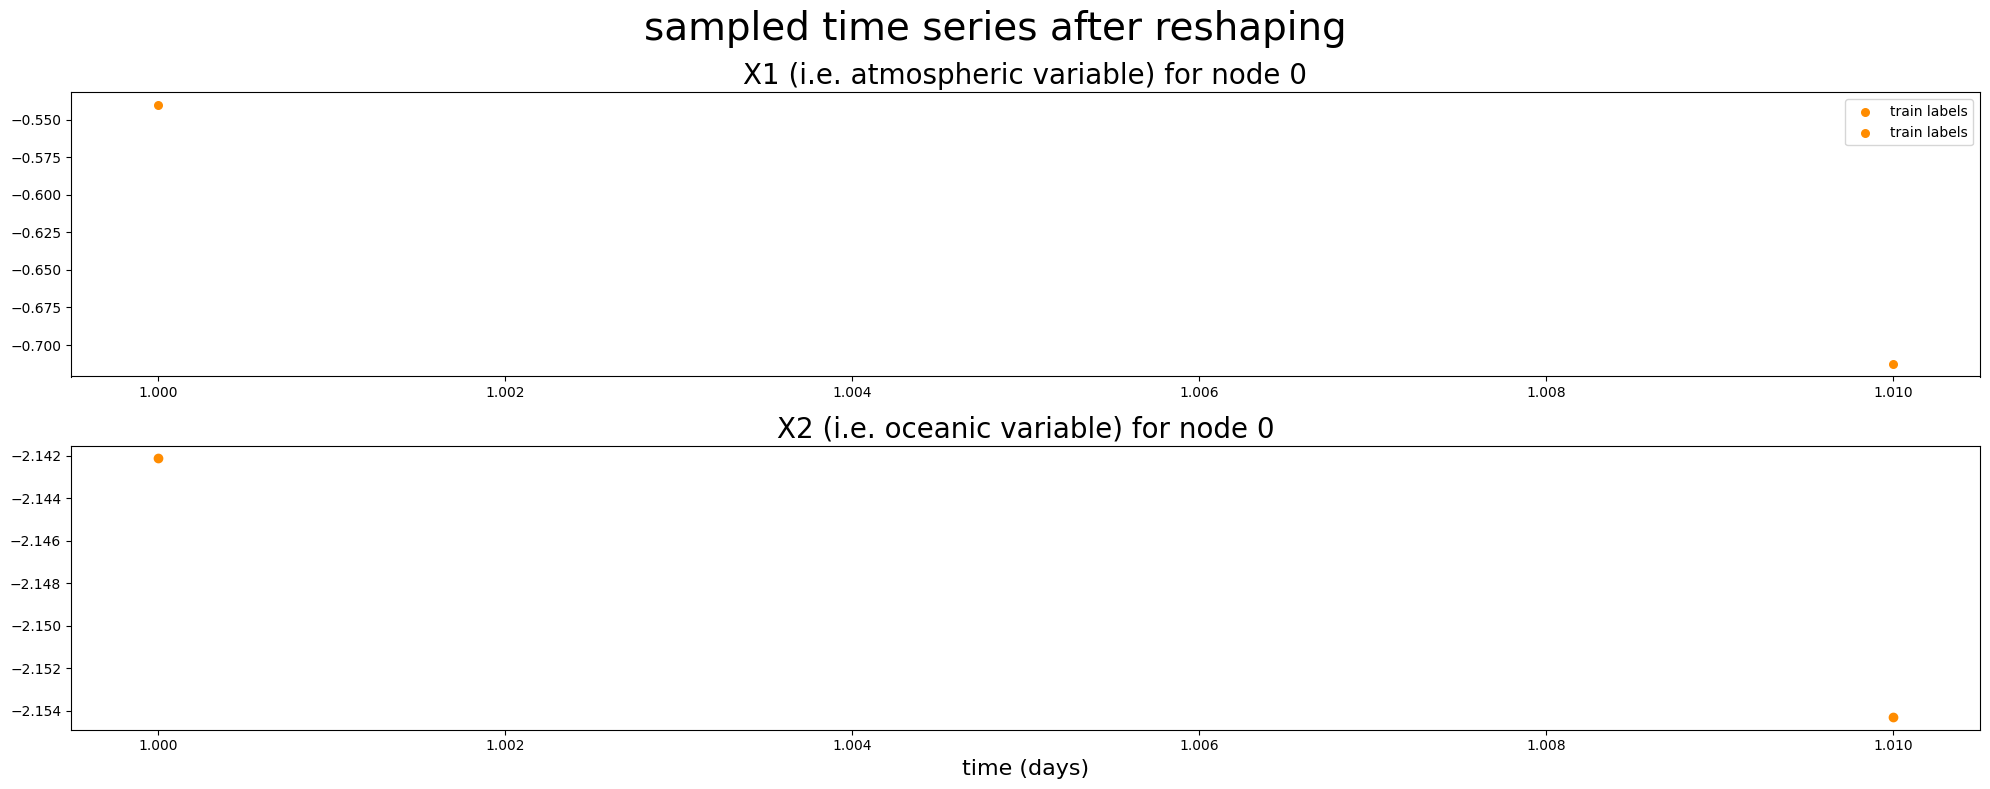

In [120]:
fig, (ax0, ax1) = plot_data(dataset_2.train, node=0, alpha=1)

plt.tight_layout()
plt.show()

plotting train
no val data to plot
no training data to plot
editing legend


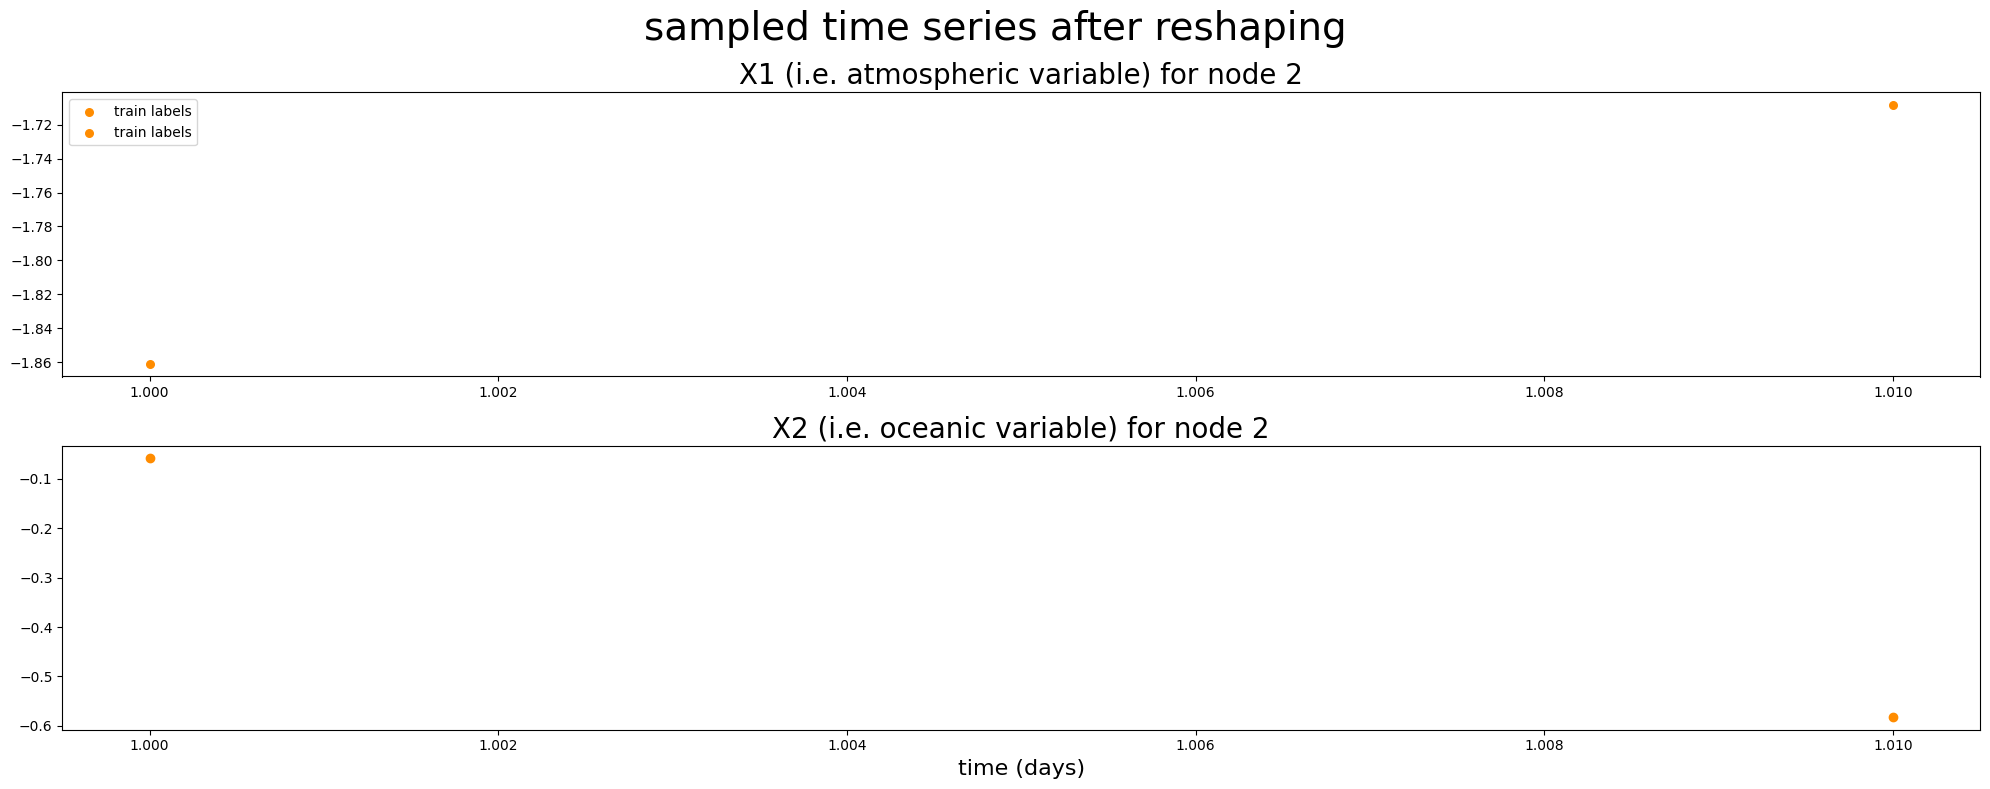

In [121]:
fig, (ax0, ax1) = plot_data(dataset_2.train, node=2, alpha=1)

plt.tight_layout()
plt.show()

plotting train
no val data to plot
no training data to plot
editing legend


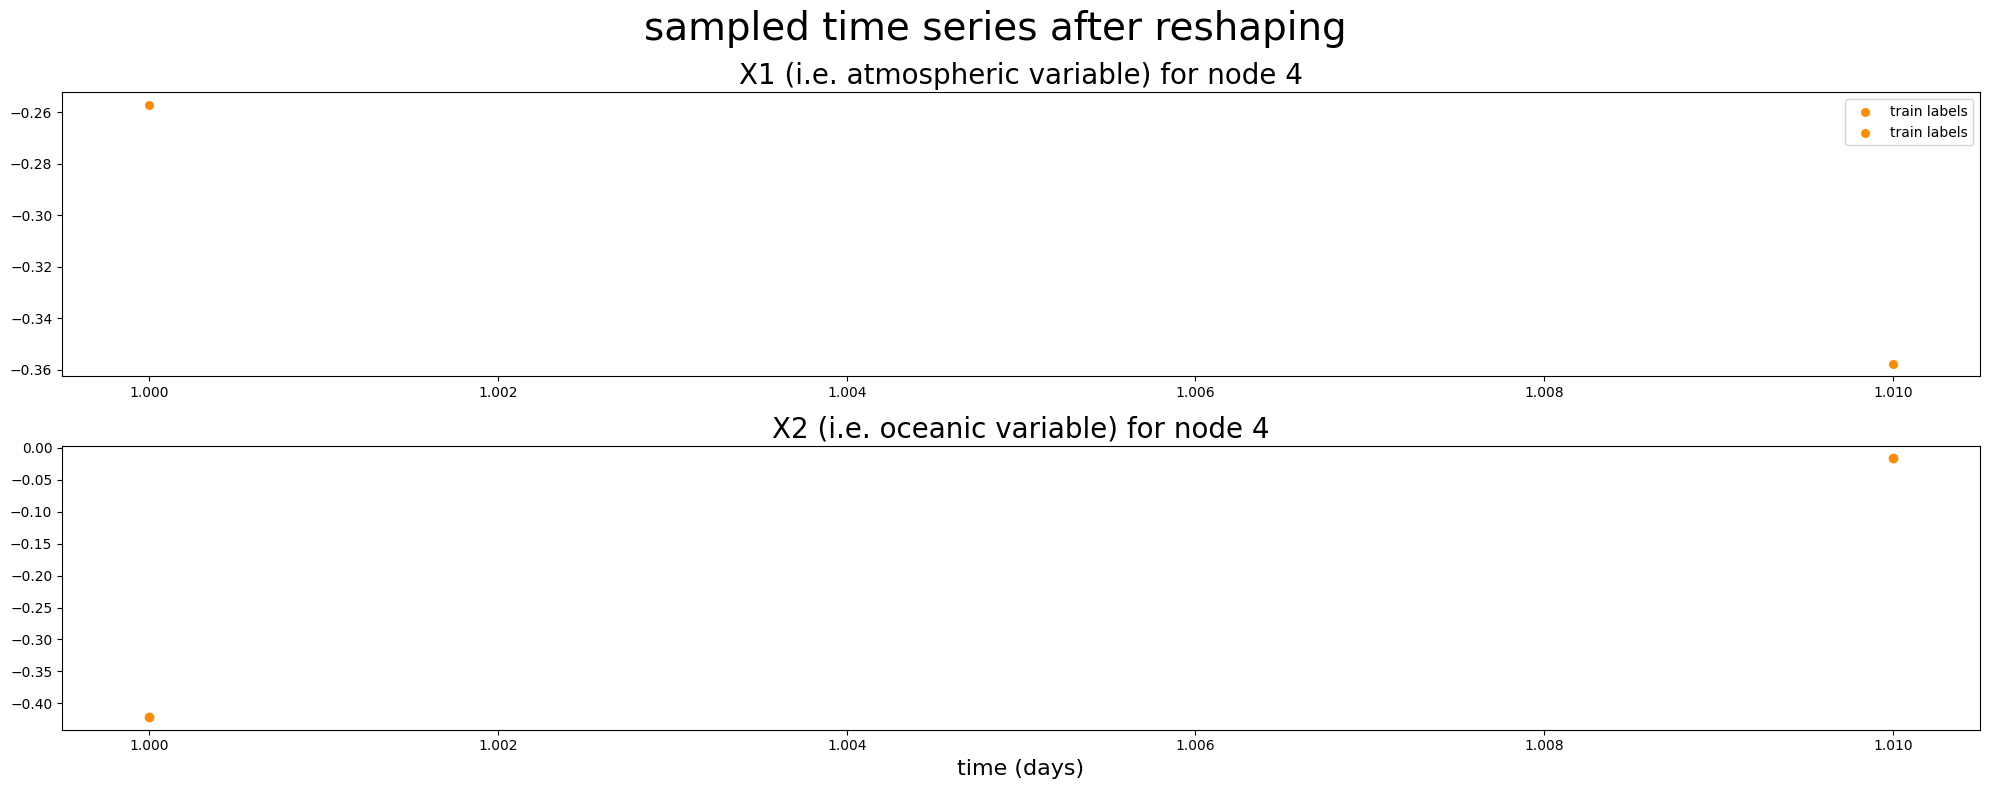

In [122]:
fig, (ax0, ax1) = plot_data(dataset_2.train, node=4, alpha=1)

plt.tight_layout()
plt.show()

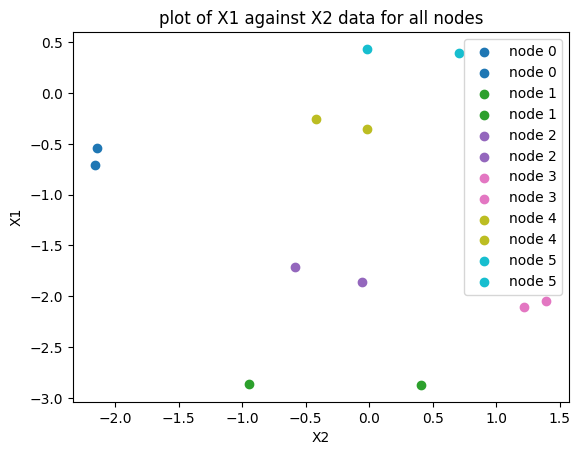

In [123]:
# plot all the X2 data against the X1 data
colors = plt.cm.tab10(np.linspace(0, 1, dataset_2.train.n_nodes))
ax = plt.subplot(1, 1, 1)

for n in range(dataset_2.train.n_nodes):
    for g in dataset_2.train:
        ax.scatter(g.x[n], g.y[n], color=colors[n], label='node {}'.format(n))

ax.set_xlabel('X2')
ax.set_ylabel('X1')
ax.set_title('plot of X1 against X2 data for all nodes')
ax.legend()

so there is very little linear correlation between X1 and X2. 

TODO: in separate notebook, show what it looks like when you change the coupling parameter.

####  train 2-layer GCN (32 channels)

For the record, the following number of channels are chosen pretty arbitrarily – I don't have a good intuition for how much this should be, and I should do some hyperparameter testing on this later. 32 is simply chosen bc it was the default number in the Spektral GCN. 

In [146]:
GCN_2_32, history_2_32, fname_2_32 = make_train_GCN(dataset_2.train,
                                           val=None,
                                           channels=32,
                                           activation="relu",
                                           dropout_rate=0,
                                           l2_reg=0,
                                           epochs=500,
                                           eval_val=False,
                                           early_stopping=False,
                                           verbose=0)


in train_model
compile model
fit model
saving model


INFO:tensorflow:Assets written to: saved_models/gcn_9-20230307-120640/assets


INFO:tensorflow:Assets written to: saved_models/gcn_9-20230307-120640/assets


In [147]:
GCN_2_32.summary()

Model: "gcn_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_30 (Dropout)        multiple                  0         
                                                                 
 gcn_conv_30 (GCNConv)       multiple                  32        
                                                                 
 dropout_31 (Dropout)        multiple                  0         
                                                                 
 gcn_conv_31 (GCNConv)       multiple                  32        
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 118ms/step
no val data to plot


(<Figure size 400x300 with 1 Axes>, <Figure size 2500x3000 with 18 Axes>, None)

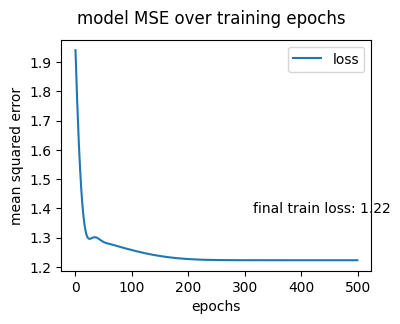

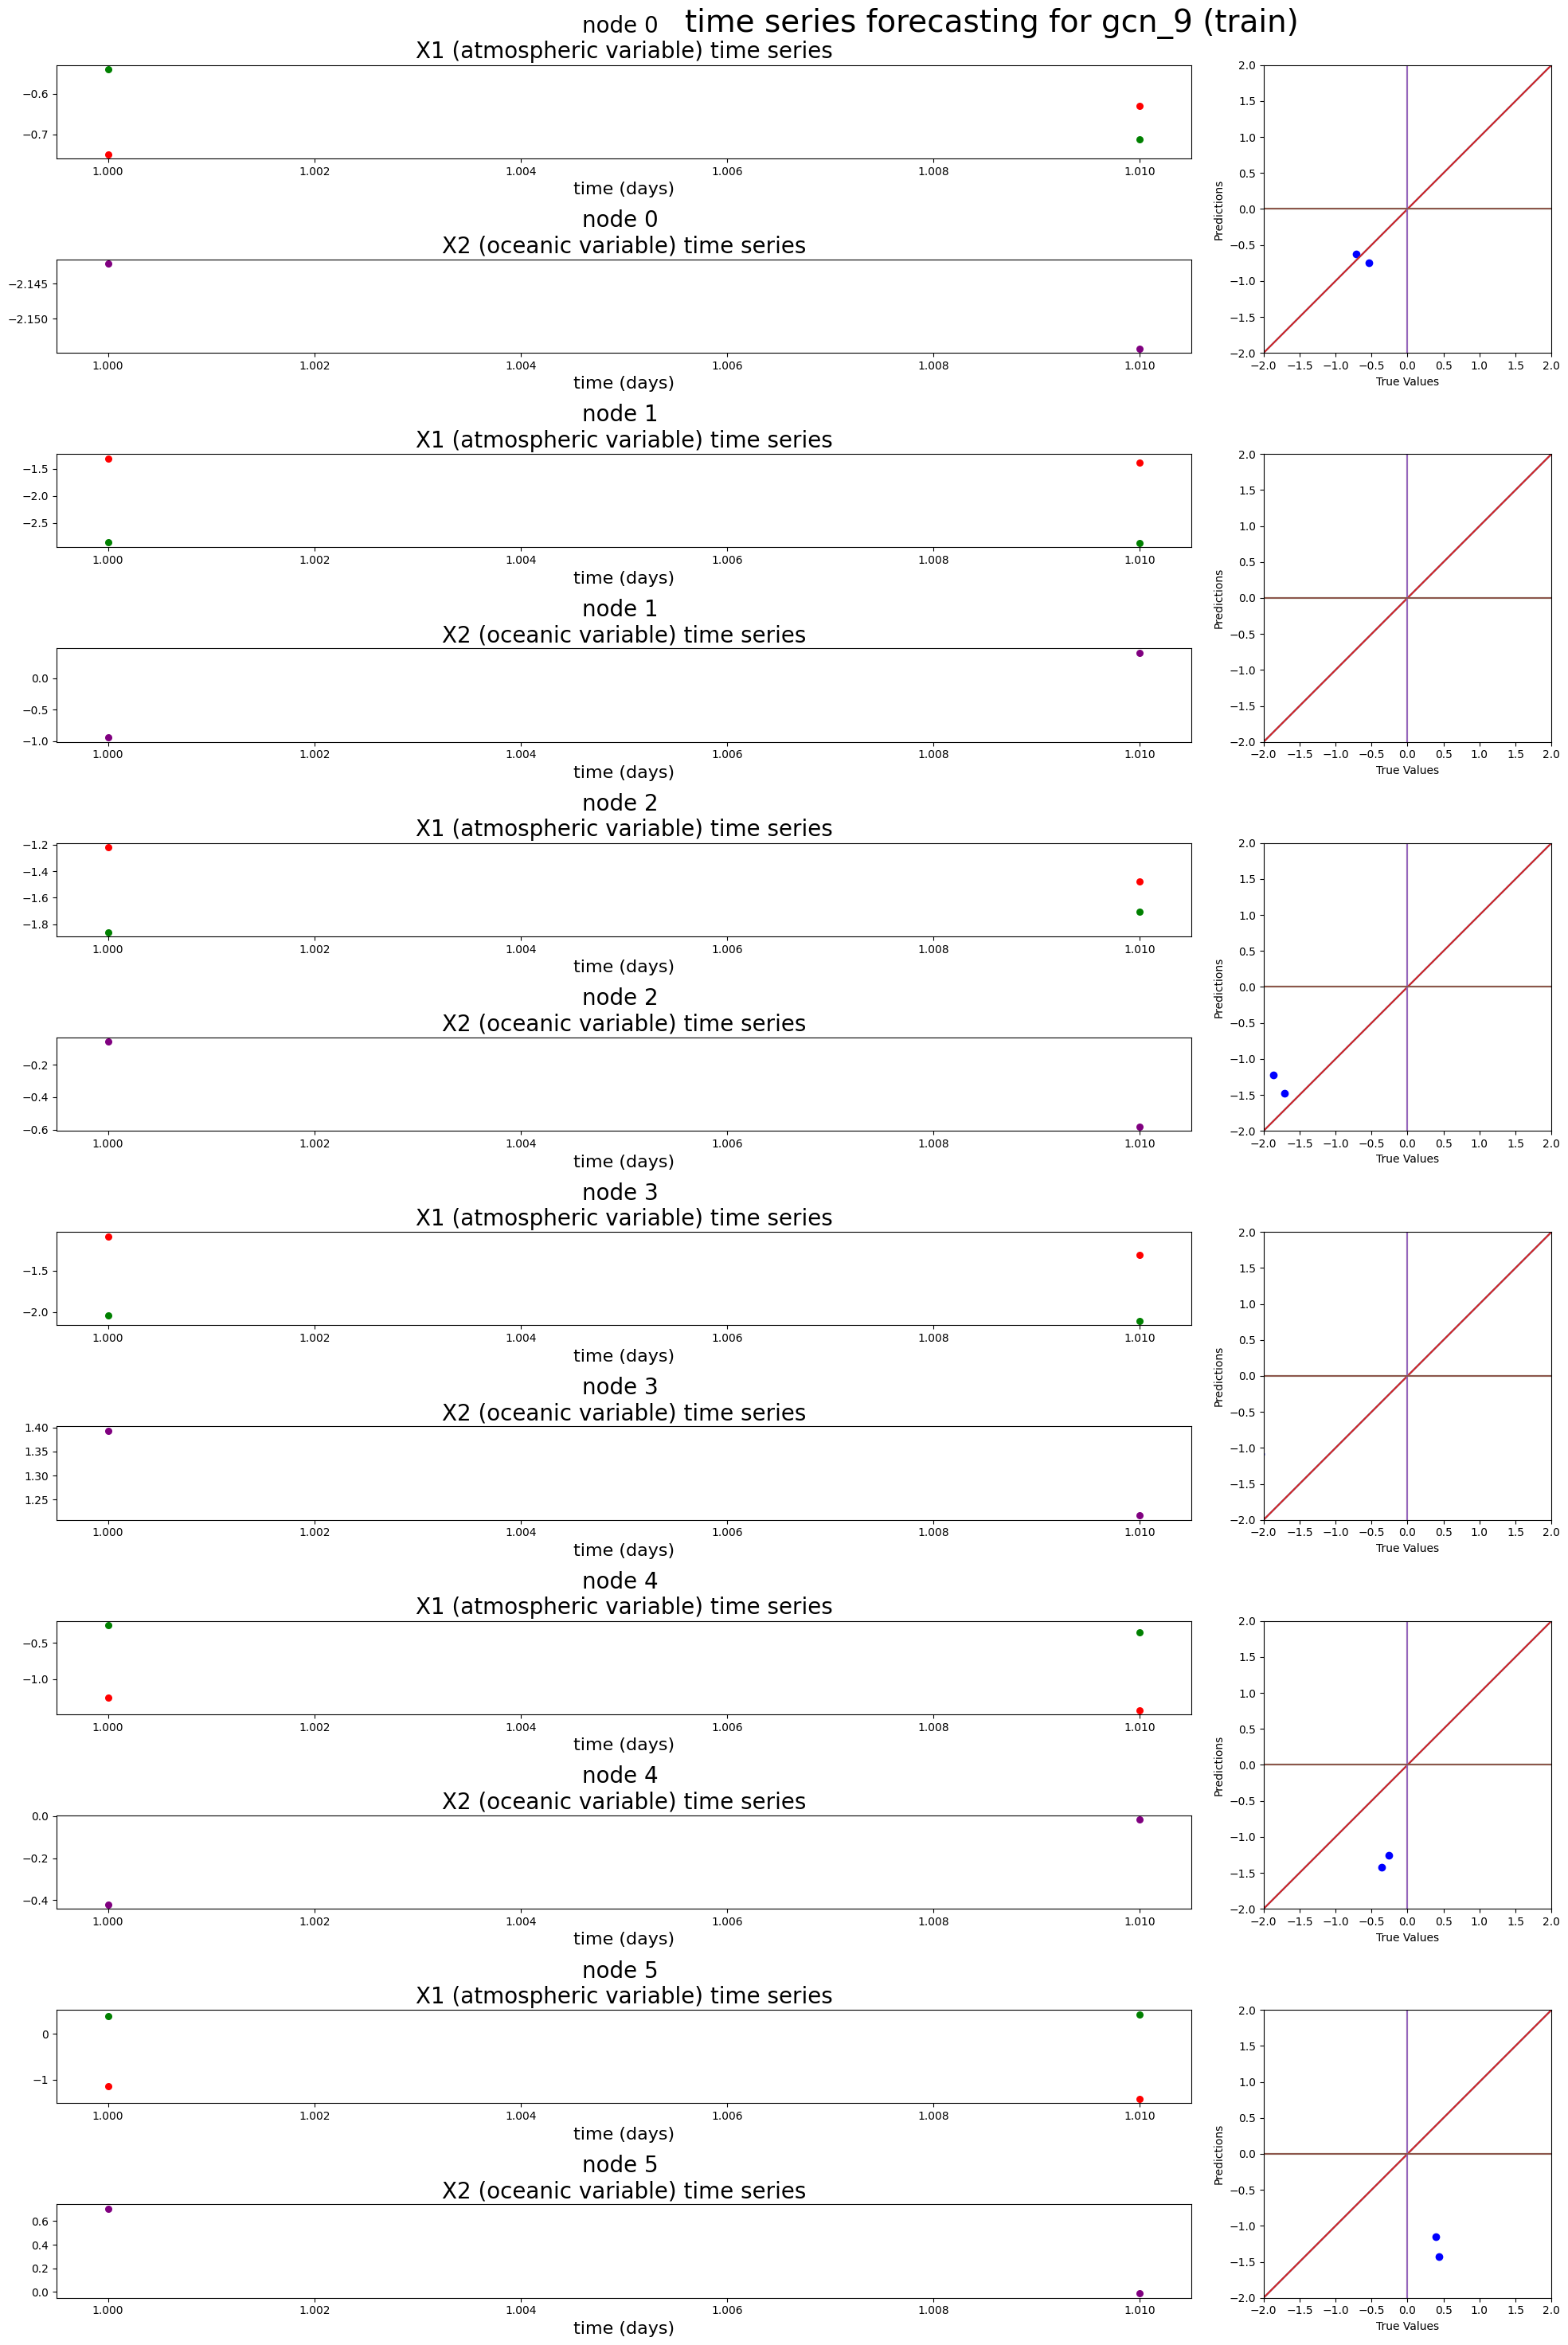

In [148]:
plot_model_results(dataset_2.train,
                   None,
                   GCN_2_32,
                   history_2_32,
                   fname_2_32,
                   nodes=range(6))


oops, the reason why it sucked at fitting at first was because I forgot to turn off the regularization and dropout. now it's looking slightly better, but with just 2x6 datapoints, I was expecting an MSE below 1, not something like 1.3 ...

#### train 2-layer GCN with 64 channels

Let's see if using more channels (and thus more parameters) will improve the model's flexibility. 

In [ ]:
GCN_2_64, history_2_64, fname_2_64 = make_train_GCN(dataset_2.train,
                                           val=None,
                                           channels=64,
                                           activation="relu",
                                           dropout_rate=0,
                                           l2_reg=0,
                                           epochs=500,
                                           eval_val=False,
                                           early_stopping=False,
                                           verbose=0)


in train_model
compile model
fit model
saving model


INFO:tensorflow:Assets written to: saved_models/gcn_10-20230307-120706/assets


INFO:tensorflow:Assets written to: saved_models/gcn_10-20230307-120706/assets


In [ ]:
GCN_2_64.summary()

Model: "gcn_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_32 (Dropout)        multiple                  0         
                                                                 
 gcn_conv_32 (GCNConv)       multiple                  3200      
                                                                 
 dropout_33 (Dropout)        multiple                  0         
                                                                 
 gcn_conv_33 (GCNConv)       multiple                  3200      
                                                                 
Total params: 6,400
Trainable params: 6,400
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 123ms/step
no val data to plot


(<Figure size 400x300 with 1 Axes>, <Figure size 2500x3000 with 18 Axes>, None)

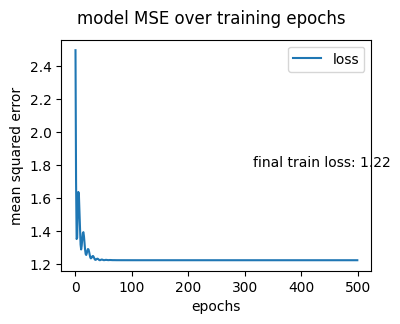

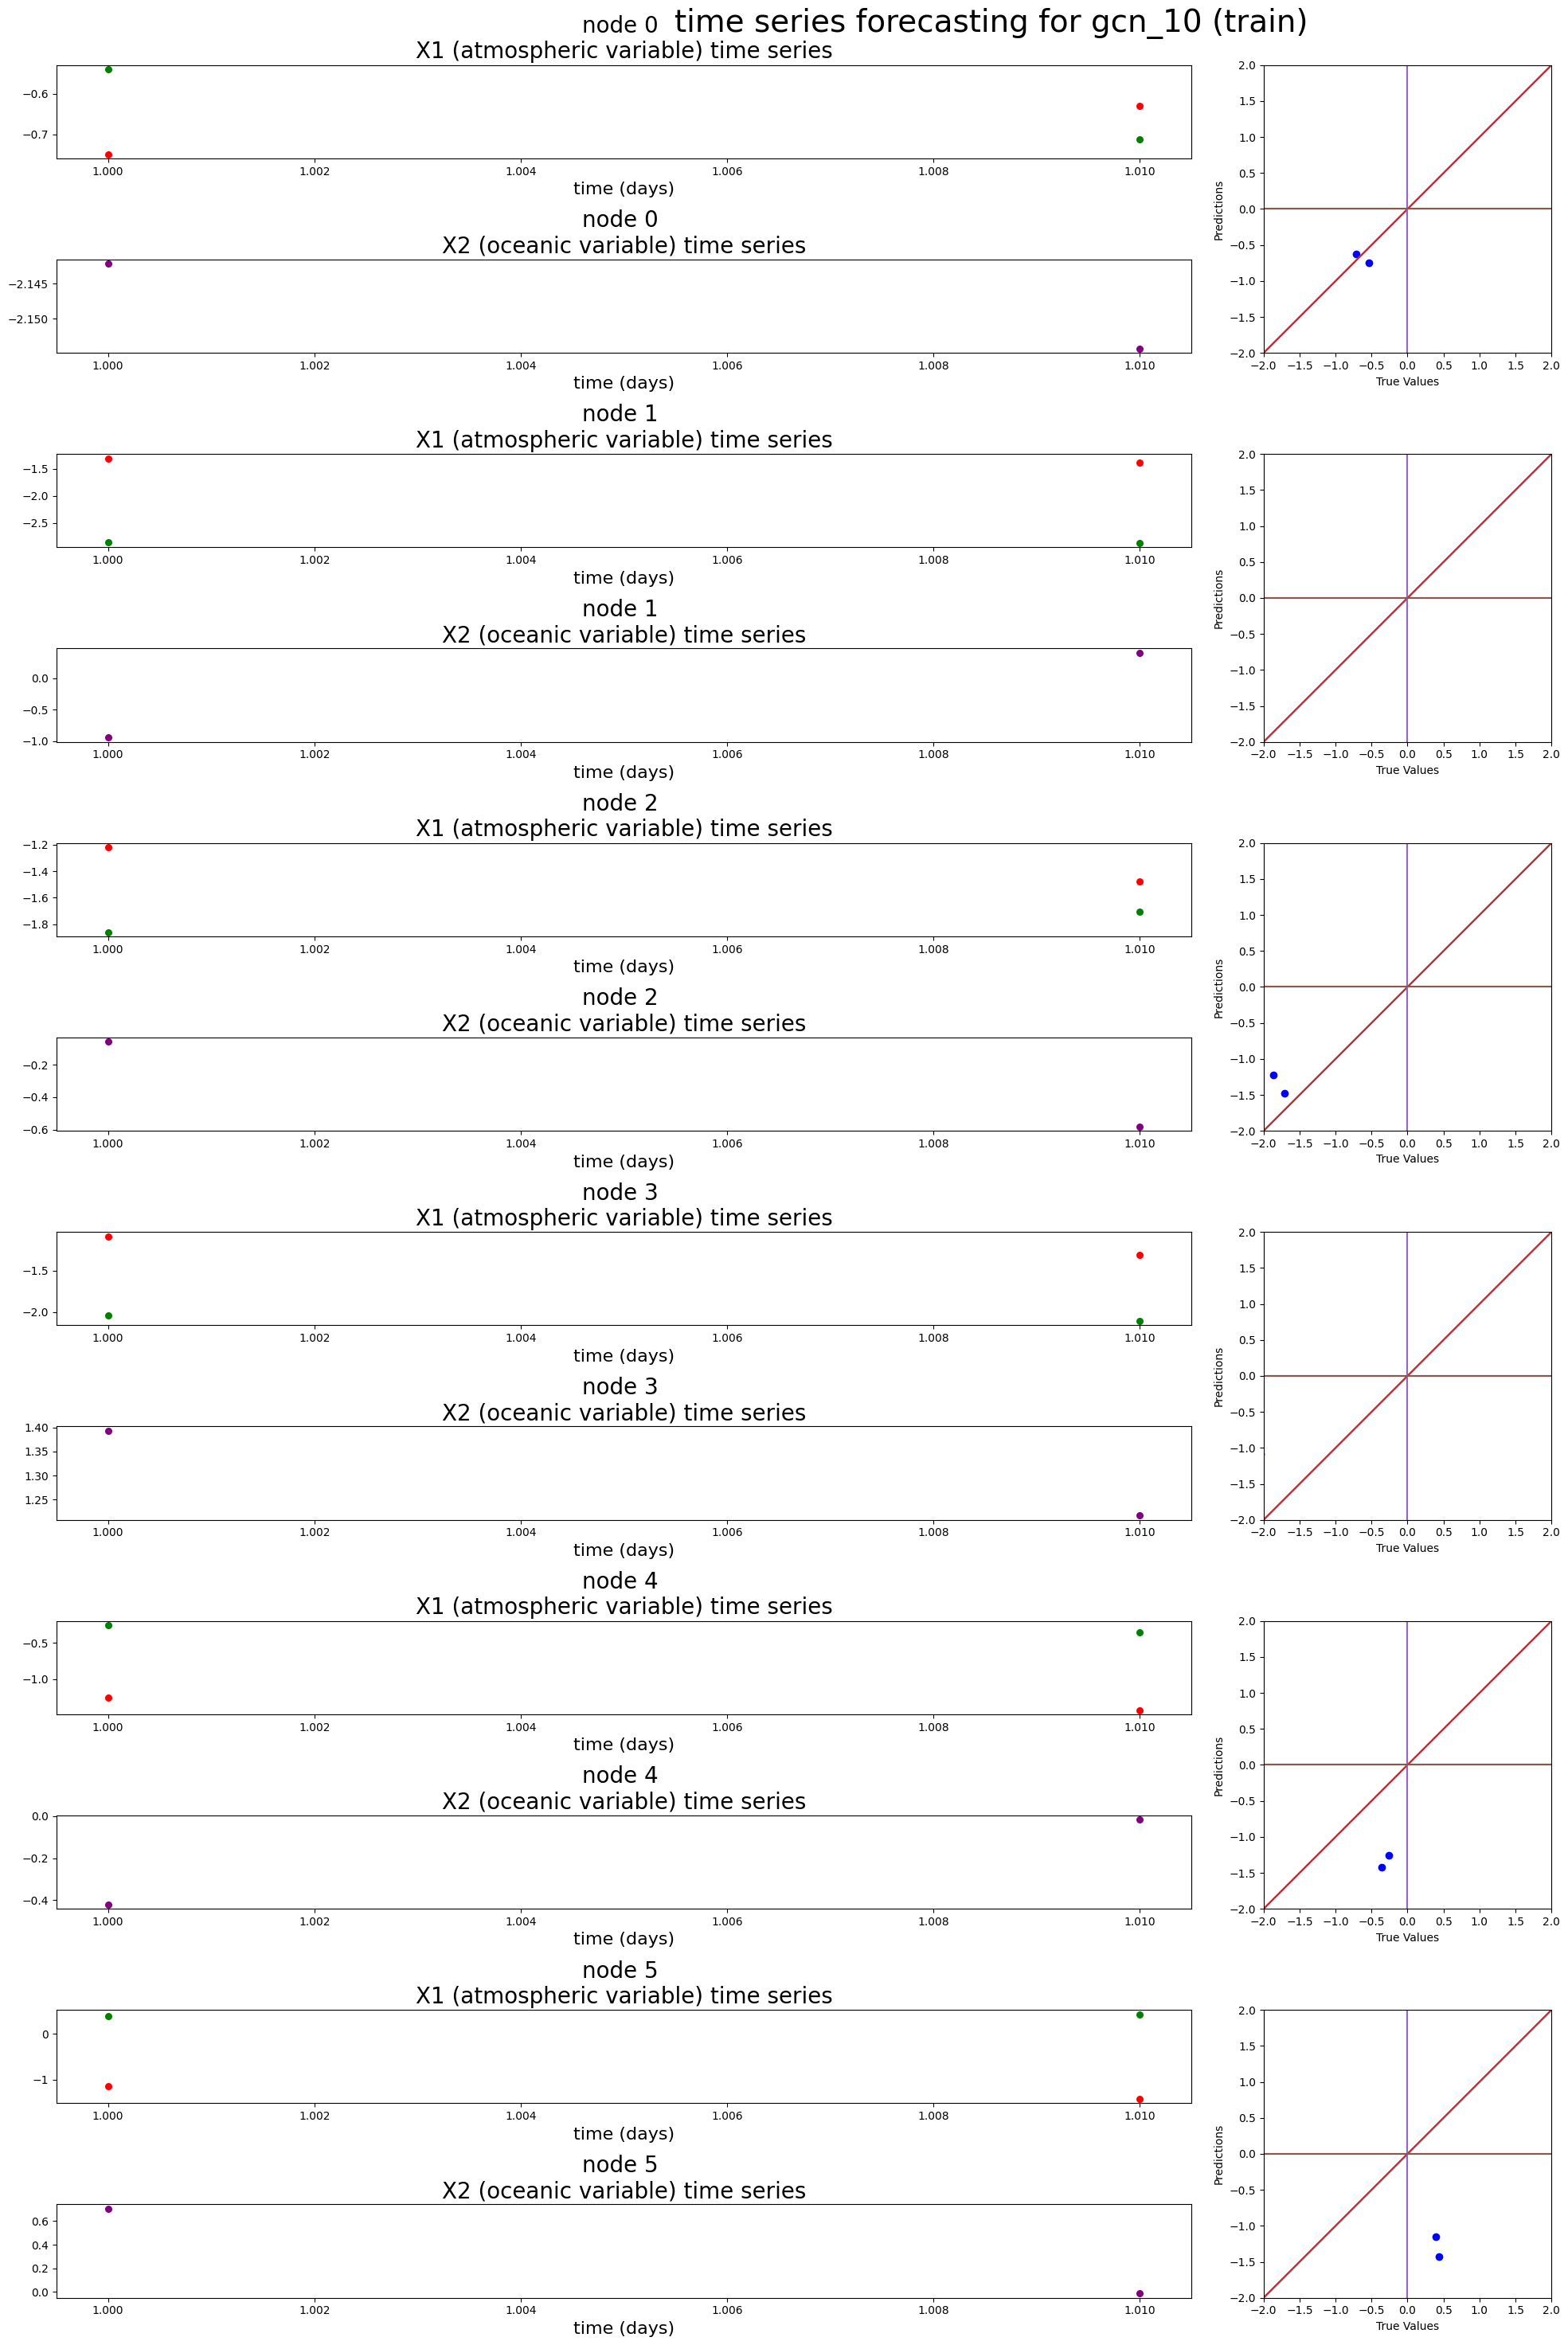

In [ ]:
plot_model_results(dataset_2.train,
                   None,
                   GCN_2_64, history_2_64, fname_2_64,
                   nodes=range(6))


The improvements from doubling the number of channels are very marginal (decrease of MSE from 1.25 to 1.22, in this round), and it didn't address the glaring issue of nodes 1 and 3 being somewhat 'outliers' and getting really bad predictions. 

#### train 2-layer GCN with 3200 channels

Just for shits and giggles, let's see what happens if we increase the number of channels to 3200. 

In [149]:
GCN_2_3200, history_2_3200, fname_2_3200 = make_train_GCN(dataset_2.train,
                                           val=None,
                                           channels=3200,
                                           activation="relu",
                                           dropout_rate=0,
                                           l2_reg=0,
                                           epochs=500,
                                           eval_val=False,
                                           early_stopping=False,
                                           verbose=0)


in train_model
compile model
fit model
saving model


INFO:tensorflow:Assets written to: saved_models/gcn_10-20230307-120706/assets


INFO:tensorflow:Assets written to: saved_models/gcn_10-20230307-120706/assets


In [150]:
GCN_2_3200.summary()

Model: "gcn_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_32 (Dropout)        multiple                  0         
                                                                 
 gcn_conv_32 (GCNConv)       multiple                  3200      
                                                                 
 dropout_33 (Dropout)        multiple                  0         
                                                                 
 gcn_conv_33 (GCNConv)       multiple                  3200      
                                                                 
Total params: 6,400
Trainable params: 6,400
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 123ms/step
no val data to plot


(<Figure size 400x300 with 1 Axes>, <Figure size 2500x3000 with 18 Axes>, None)

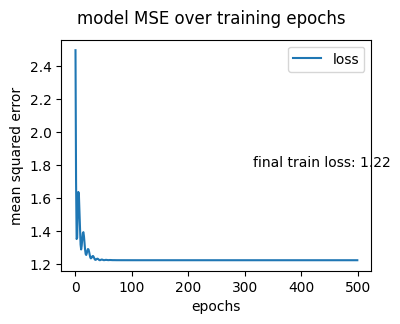

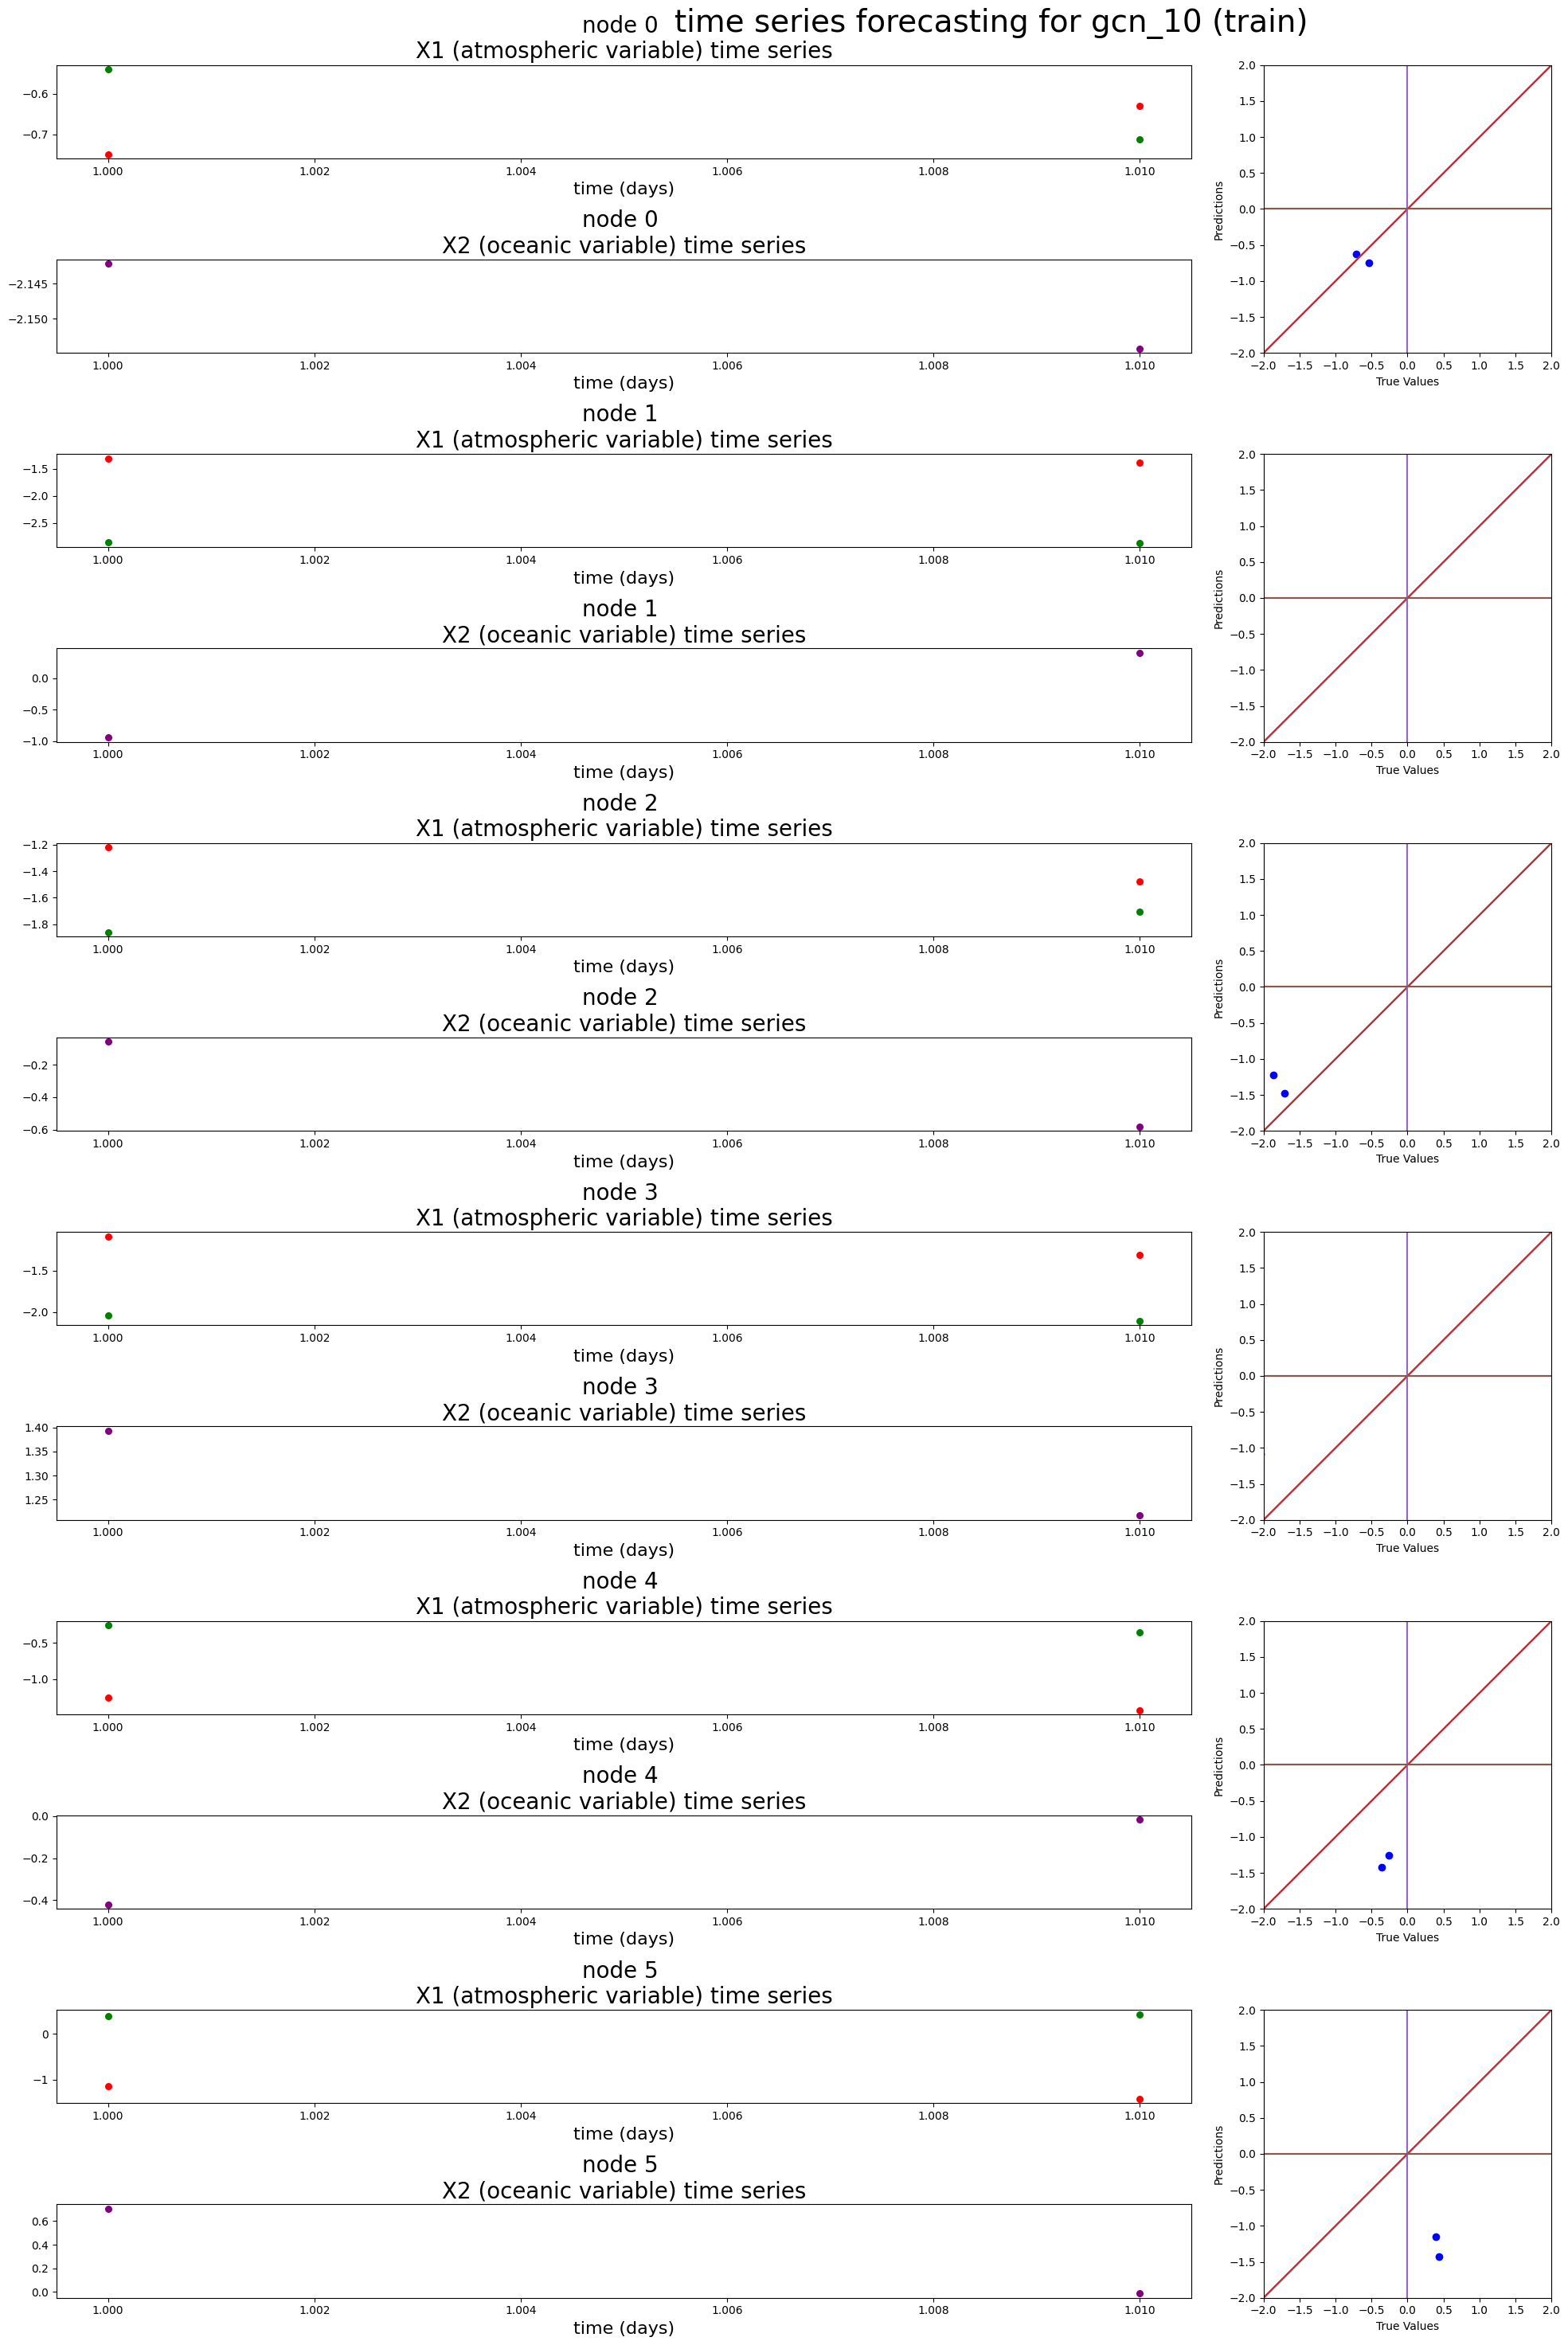

In [151]:
plot_model_results(dataset_2.train,
                   None,
                   GCN_2_3200,
                   history_2_3200,
                   fname_2_3200,
                   nodes=range(6))


Wow, there are like no improvements at all. Is this concerning? I want to look into this more later. 

#### train 3-layer GCN

Let's see if increasing the number of parameters by increasing the number of layers helps with anything. Again, number of channels has been chosen arbitrarily. 

In [126]:
GCN3_2, history3_2, fname3_2 = make_train_GCN3(dataset_2.train,
                                               val=None,
                                               channels_0=64,
                                               channels_1=32,
                                               activation="relu",
                                               dropout_rate=0,
                                               l2_reg=0,
                                               epochs=500,
                                               eval_val=False,
                                               early_stopping=False,
                                               verbose=0)


in make_train_GCN3
in train_model
compile model
fit model
saving model


INFO:tensorflow:Assets written to: saved_models/gcn3_3-20230307-115858/assets


INFO:tensorflow:Assets written to: saved_models/gcn3_3-20230307-115858/assets


1/1 [==============================] - 0s 174ms/step
no val data to plot


(<Figure size 400x300 with 1 Axes>, <Figure size 2500x3000 with 18 Axes>, None)

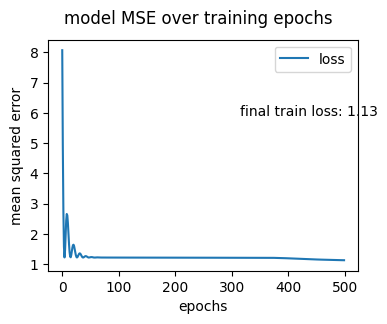

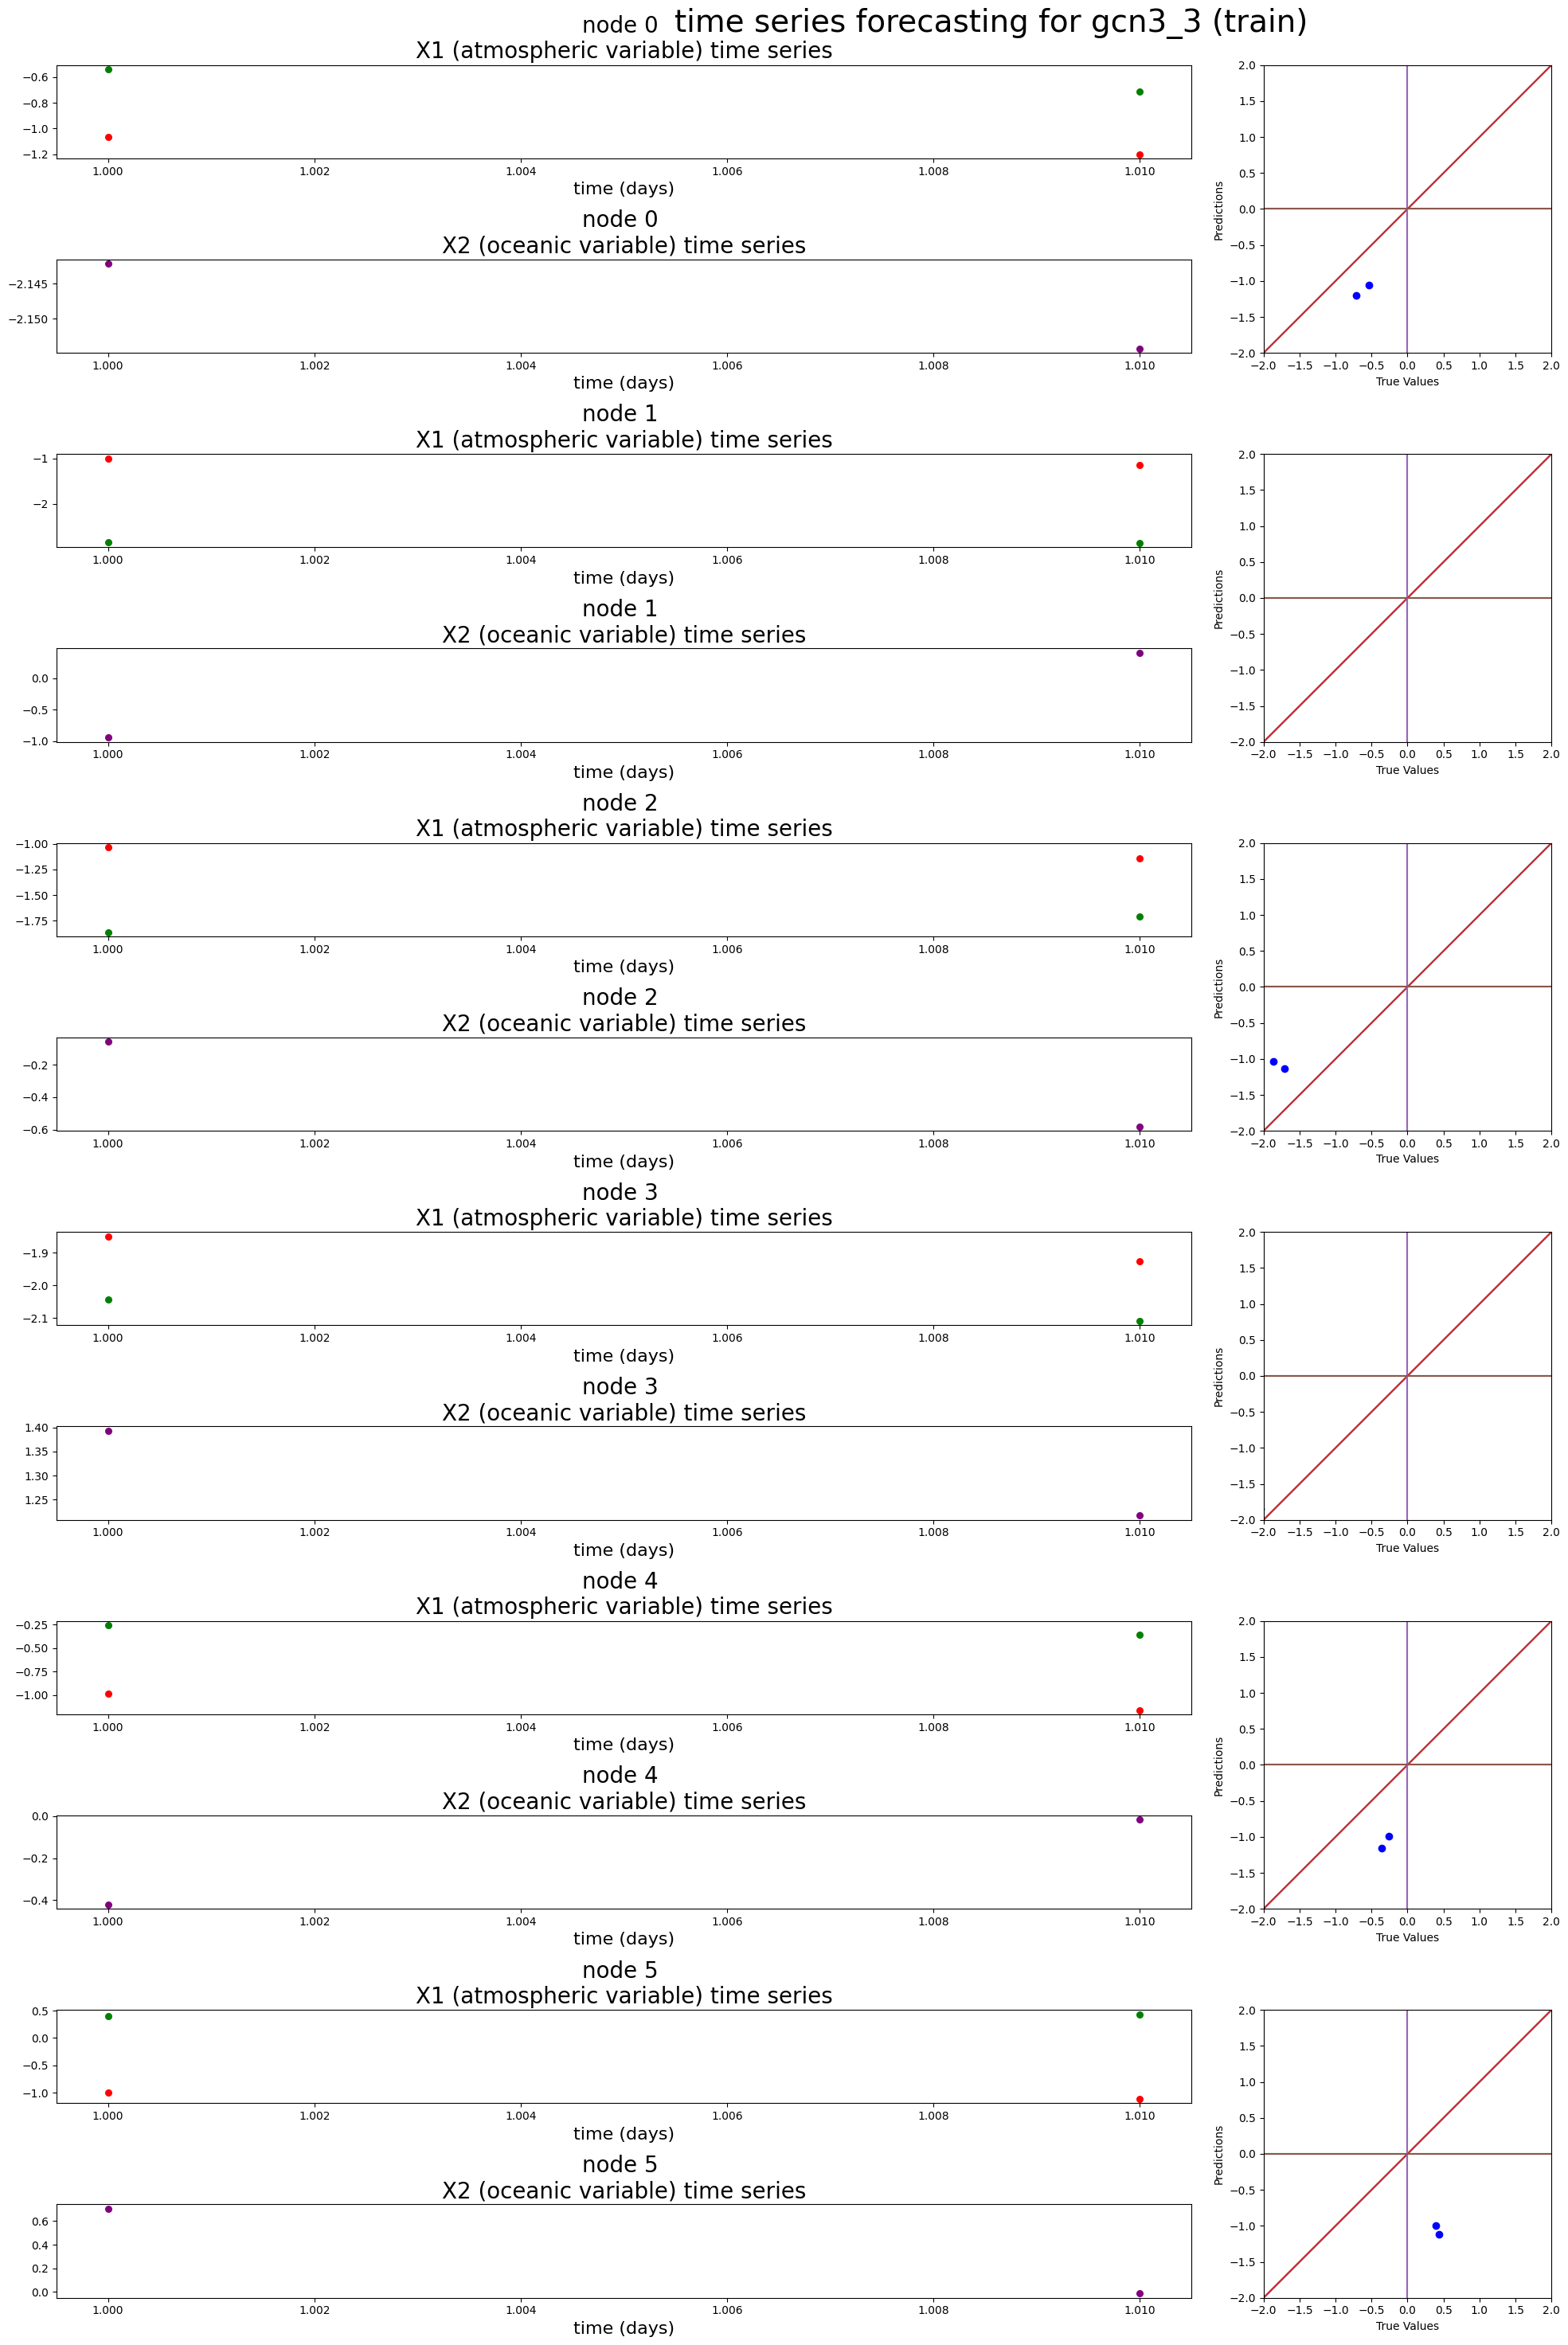

In [127]:
plot_model_results(dataset_2.train,
                   None,
                   GCN3_2,
                   history3_2,
                   fname3_2,
                   nodes=range(6))

so adding a layer to the model did marginally improve predictions moreso than simply increasing the number of channels. Compared to a 2-layer 64-channel GCN, this 3-layer one reduced the MSE from 1.22 to 1.13. 

STILL, THIS IS NOT THE FACTOR OF IMPROVEMENTS WE WANT TO SEE. WE ONLY HAVE 12 DATA POINTS, I WAS HOPING WE WOULD GET AN MSE BELOW 1! 

### 5 data points

#### prepare data

In [128]:
# only uncomment each line if testing a non-default parameter
dataset_5 = lorenzDatasetWrapper(
    predict_from="X2",
    n_samples=5,
    # input_steps=2 * DEFAULT_TIME_RESOLUTION,  # 2 days
    # output_delay=1 * DEFAULT_TIME_RESOLUTION,  # 1 day
    # output_steps=1,
    # min_buffer=-3 * DEFAULT_TIME_RESOLUTION,
    # rand_buffer=False,
    K=6,
    # F=8,
    # c=10,
    # b=10,
    # h=1,
    # coupled=True,
    # time_resolution=DEFAULT_TIME_RESOLUTION,
    # seed=42,
    init_buffer_steps=100,
    return_buffer=True,
    train_pct=
    1,  # no train/val split since we have so few data points and just want to ensure overfitting right now
    val_pct=0,
    test_pct=0,
    override=True)


In [129]:
dataset_5.buffer

lorenzDataset(n_graphs=100)

In [130]:
dataset_5.train

lorenzDataset(n_graphs=5)

#### inspect data

In [131]:
dataset_5.train[0].x.flatten()

array([-2.13667169, -0.89172131,  0.03402373,  1.54730929, -0.34342456,
        0.83147955])

In [132]:
dataset_5.train[4].x.flatten()

array([-0.05462505,  0.56188295,  0.07571996, -0.74416016,  0.66827646,
        0.68042796])

In [133]:
dataset_5.train[0].y.flatten()

array([ 2.63985808, -8.79928894, -3.87473317, -4.77442743,  4.03668411,
        7.24144028])

In [134]:
dataset_5.train[4].y.flatten()

array([-0.60695552, -8.56277169, -1.25719938, -5.46197255,  2.10869807,
        7.73509209])

#### normalize

In [152]:
dataset_5.normalize()

#### inspect data

In [159]:
dataset_5.train[0].x.flatten()

array([-2.16590153, -0.96104763, -0.06511831,  1.39942842, -0.43041002,
        0.70665361])

In [160]:
dataset_5.train[4].x.flatten()

array([-0.15091196,  0.44573999, -0.02476501, -0.81823901,  0.54870686,
        0.56046699])

In [161]:
dataset_5.train[0].y.flatten()

array([-0.4924961 , -2.75640858, -1.78179367, -1.95985144, -0.21605137,
        0.41819938])

In [162]:
dataset_5.train[4].y.flatten()

array([-1.13507039, -2.70959964, -1.26375964, -2.09592295, -0.59761755,
        0.51589761])

#### plot data

plotting train
no val data to plot
no training data to plot
editing legend


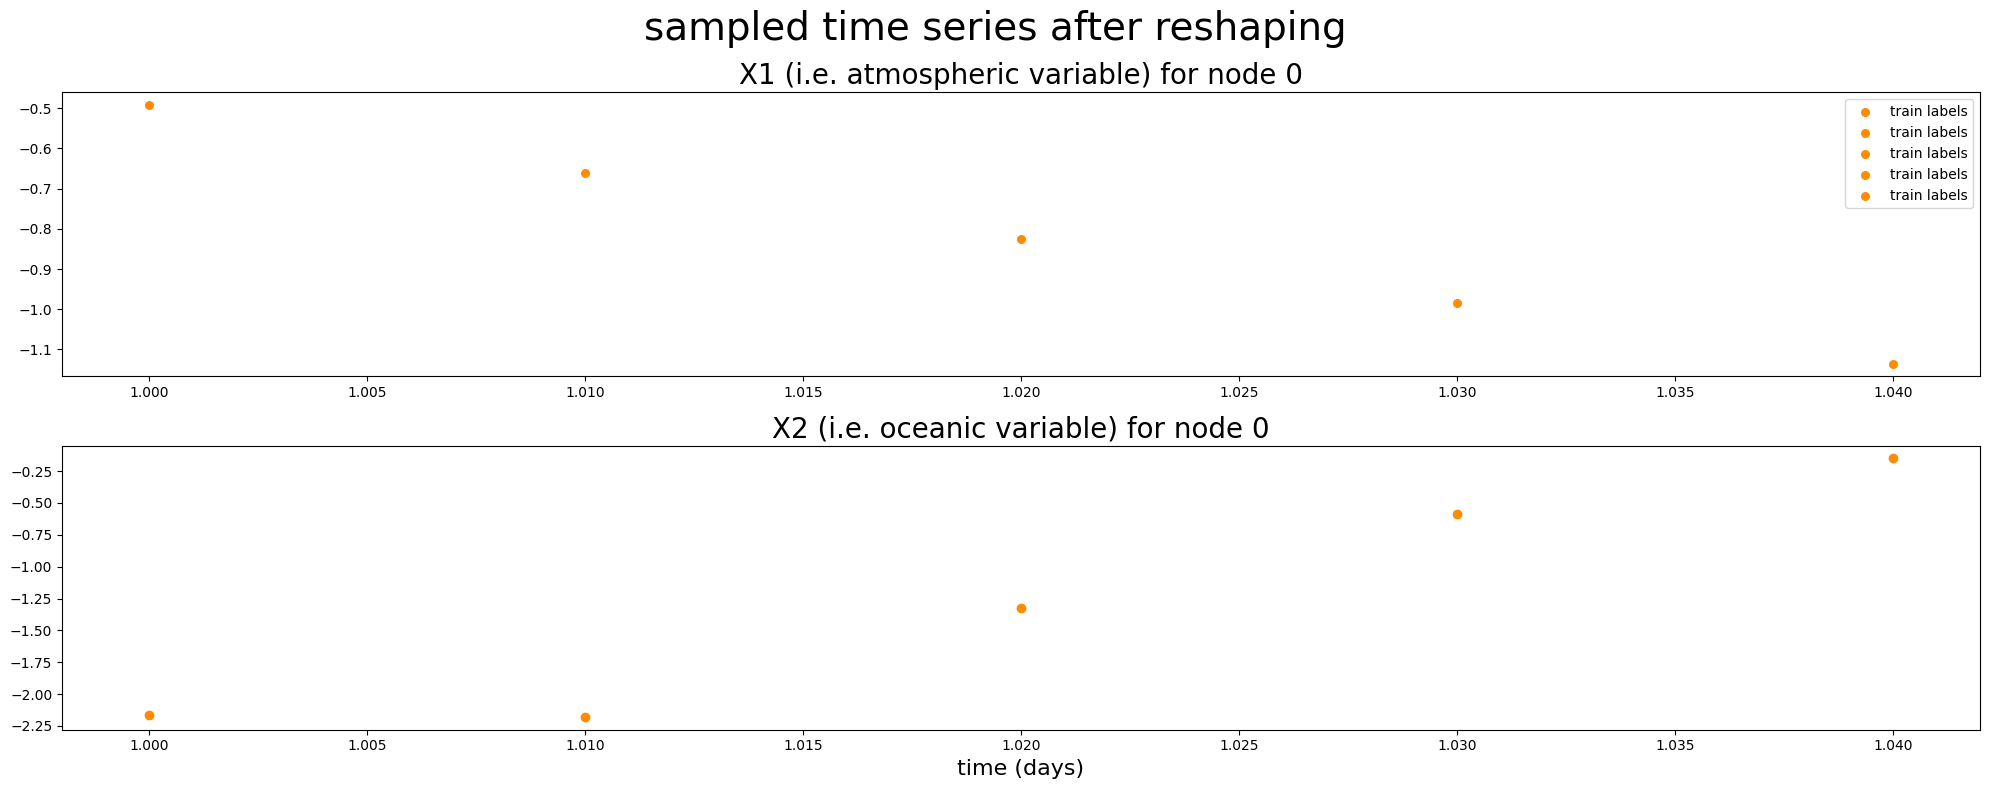

In [163]:
fig, (ax0, ax1) = plot_data(dataset_5.train, node=0, alpha=1)

plt.tight_layout()
plt.show()

plotting train
no val data to plot
no training data to plot
editing legend


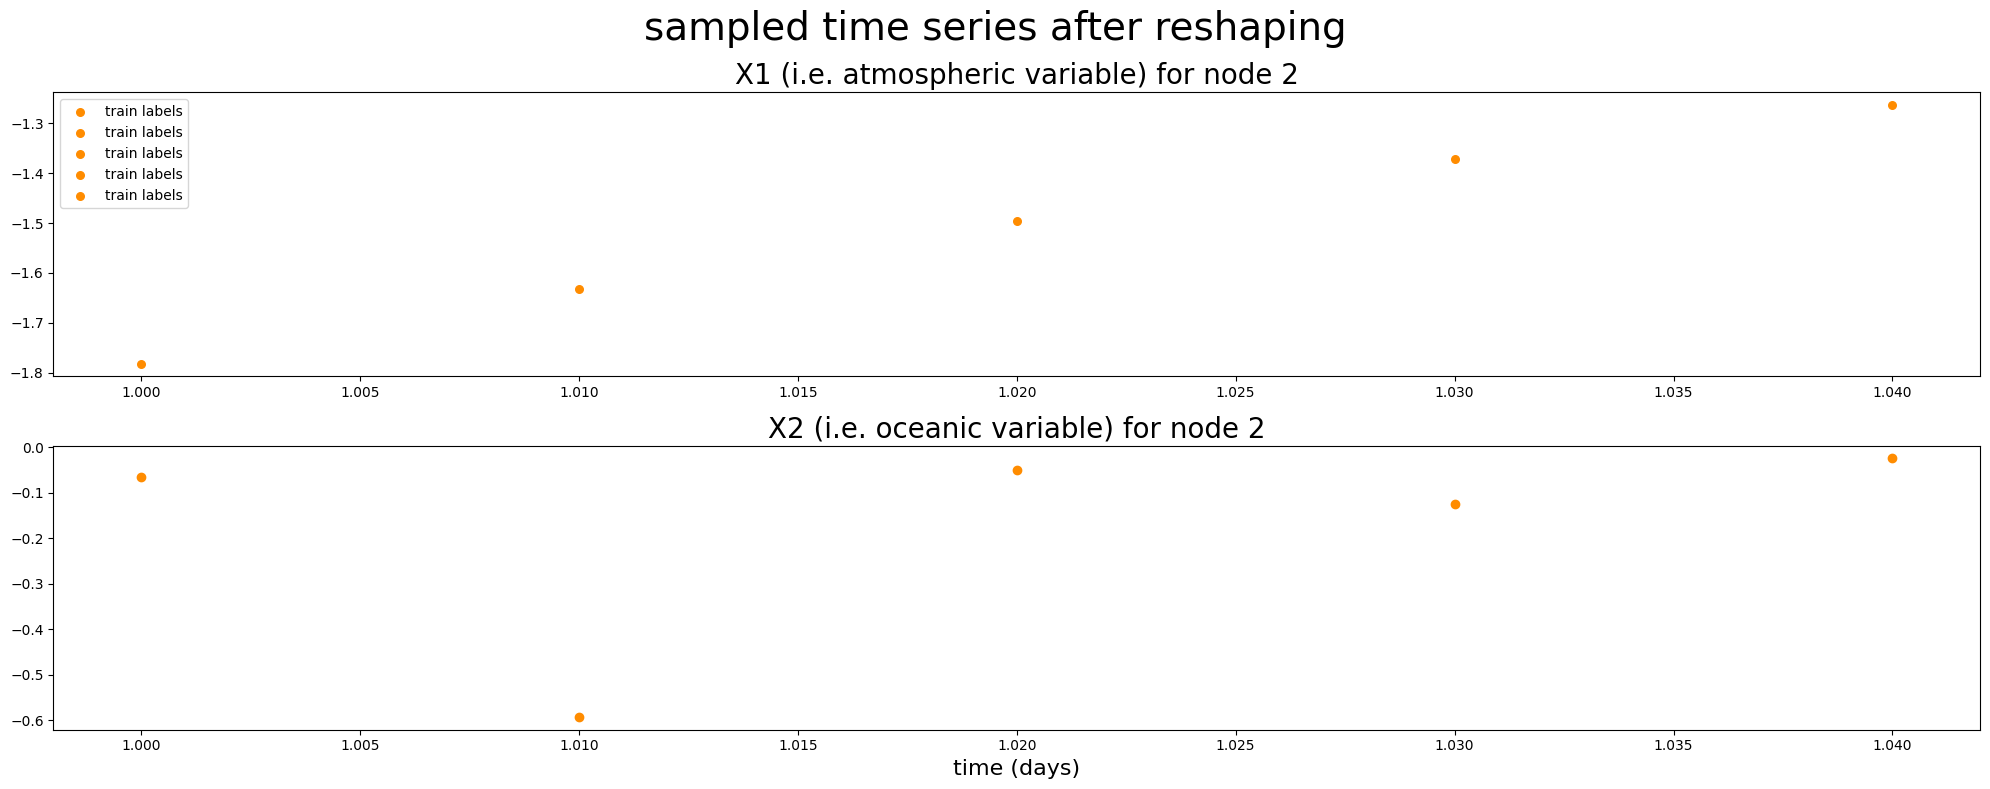

In [164]:
fig, (ax0, ax1) = plot_data(dataset_5.train, node=2, alpha=1)

plt.tight_layout()
plt.show()

plotting train
no val data to plot
no training data to plot
editing legend


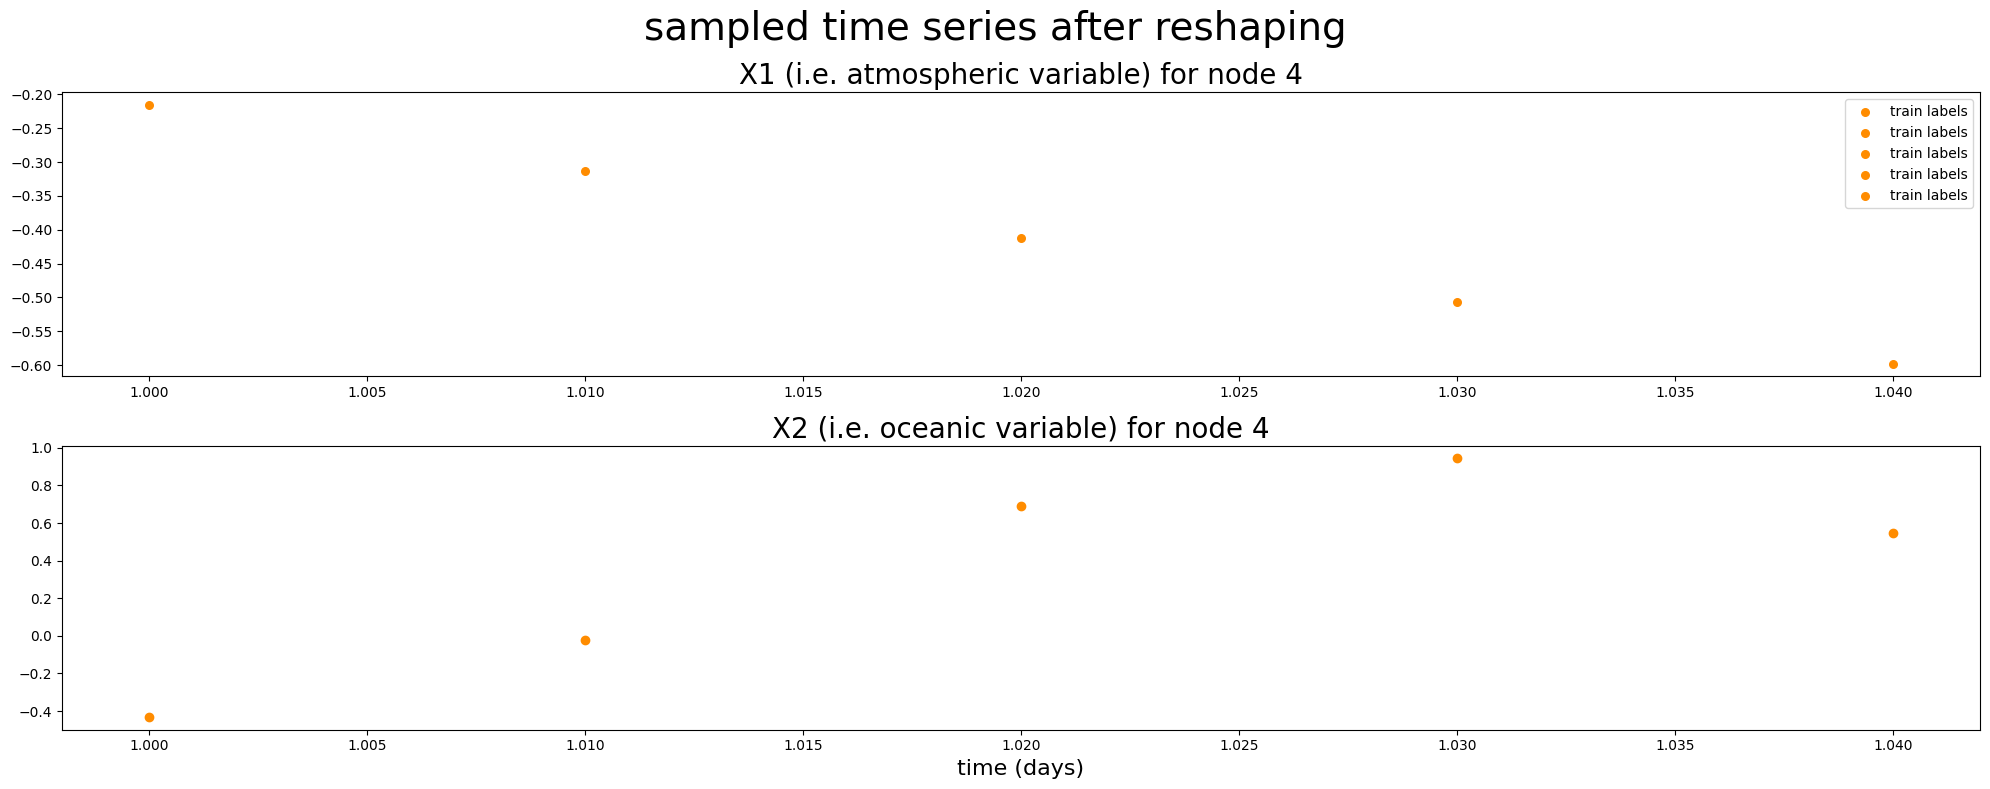

In [165]:
fig, (ax0, ax1) = plot_data(dataset_5.train, node=4, alpha=1)

plt.tight_layout()
plt.show()

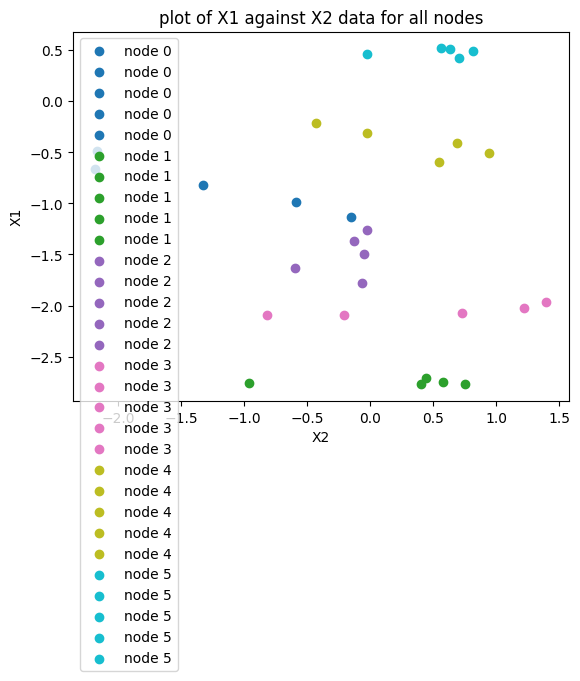

In [166]:
# plot all the X2 data against the X1 data
colors = plt.cm.tab10(np.linspace(0, 1, dataset_5.train.n_nodes))
ax = plt.subplot(1, 1, 1)

for n in range(dataset_5.train.n_nodes):
    for g in dataset_5.train:
        ax.scatter(g.x[n], g.y[n], color=colors[n], label='node {}'.format(n))

ax.set_xlabel('X2')
ax.set_ylabel('X1')
ax.set_title('plot of X1 against X2 data for all nodes')
ax.legend()

#### train 2-layer GCN

In [167]:
GCN_5, history_5, fname_5 = make_train_GCN(dataset_5.train,
                                           val=None,
                                           channels=64,
                                           activation="relu",
                                           dropout_rate=0,
                                           l2_reg=0,
                                           epochs=150,
                                           eval_val=False,
                                           early_stopping=False,
                                           verbose=0)


in train_model
compile model
fit model
saving model


INFO:tensorflow:Assets written to: saved_models/gcn_11-20230307-123351/assets


INFO:tensorflow:Assets written to: saved_models/gcn_11-20230307-123351/assets


1/1 [==============================] - 0s 191ms/step
no val data to plot


(<Figure size 400x300 with 1 Axes>, <Figure size 2500x3000 with 18 Axes>, None)

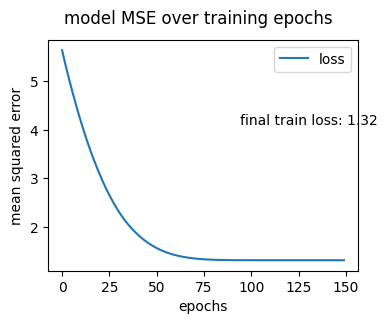

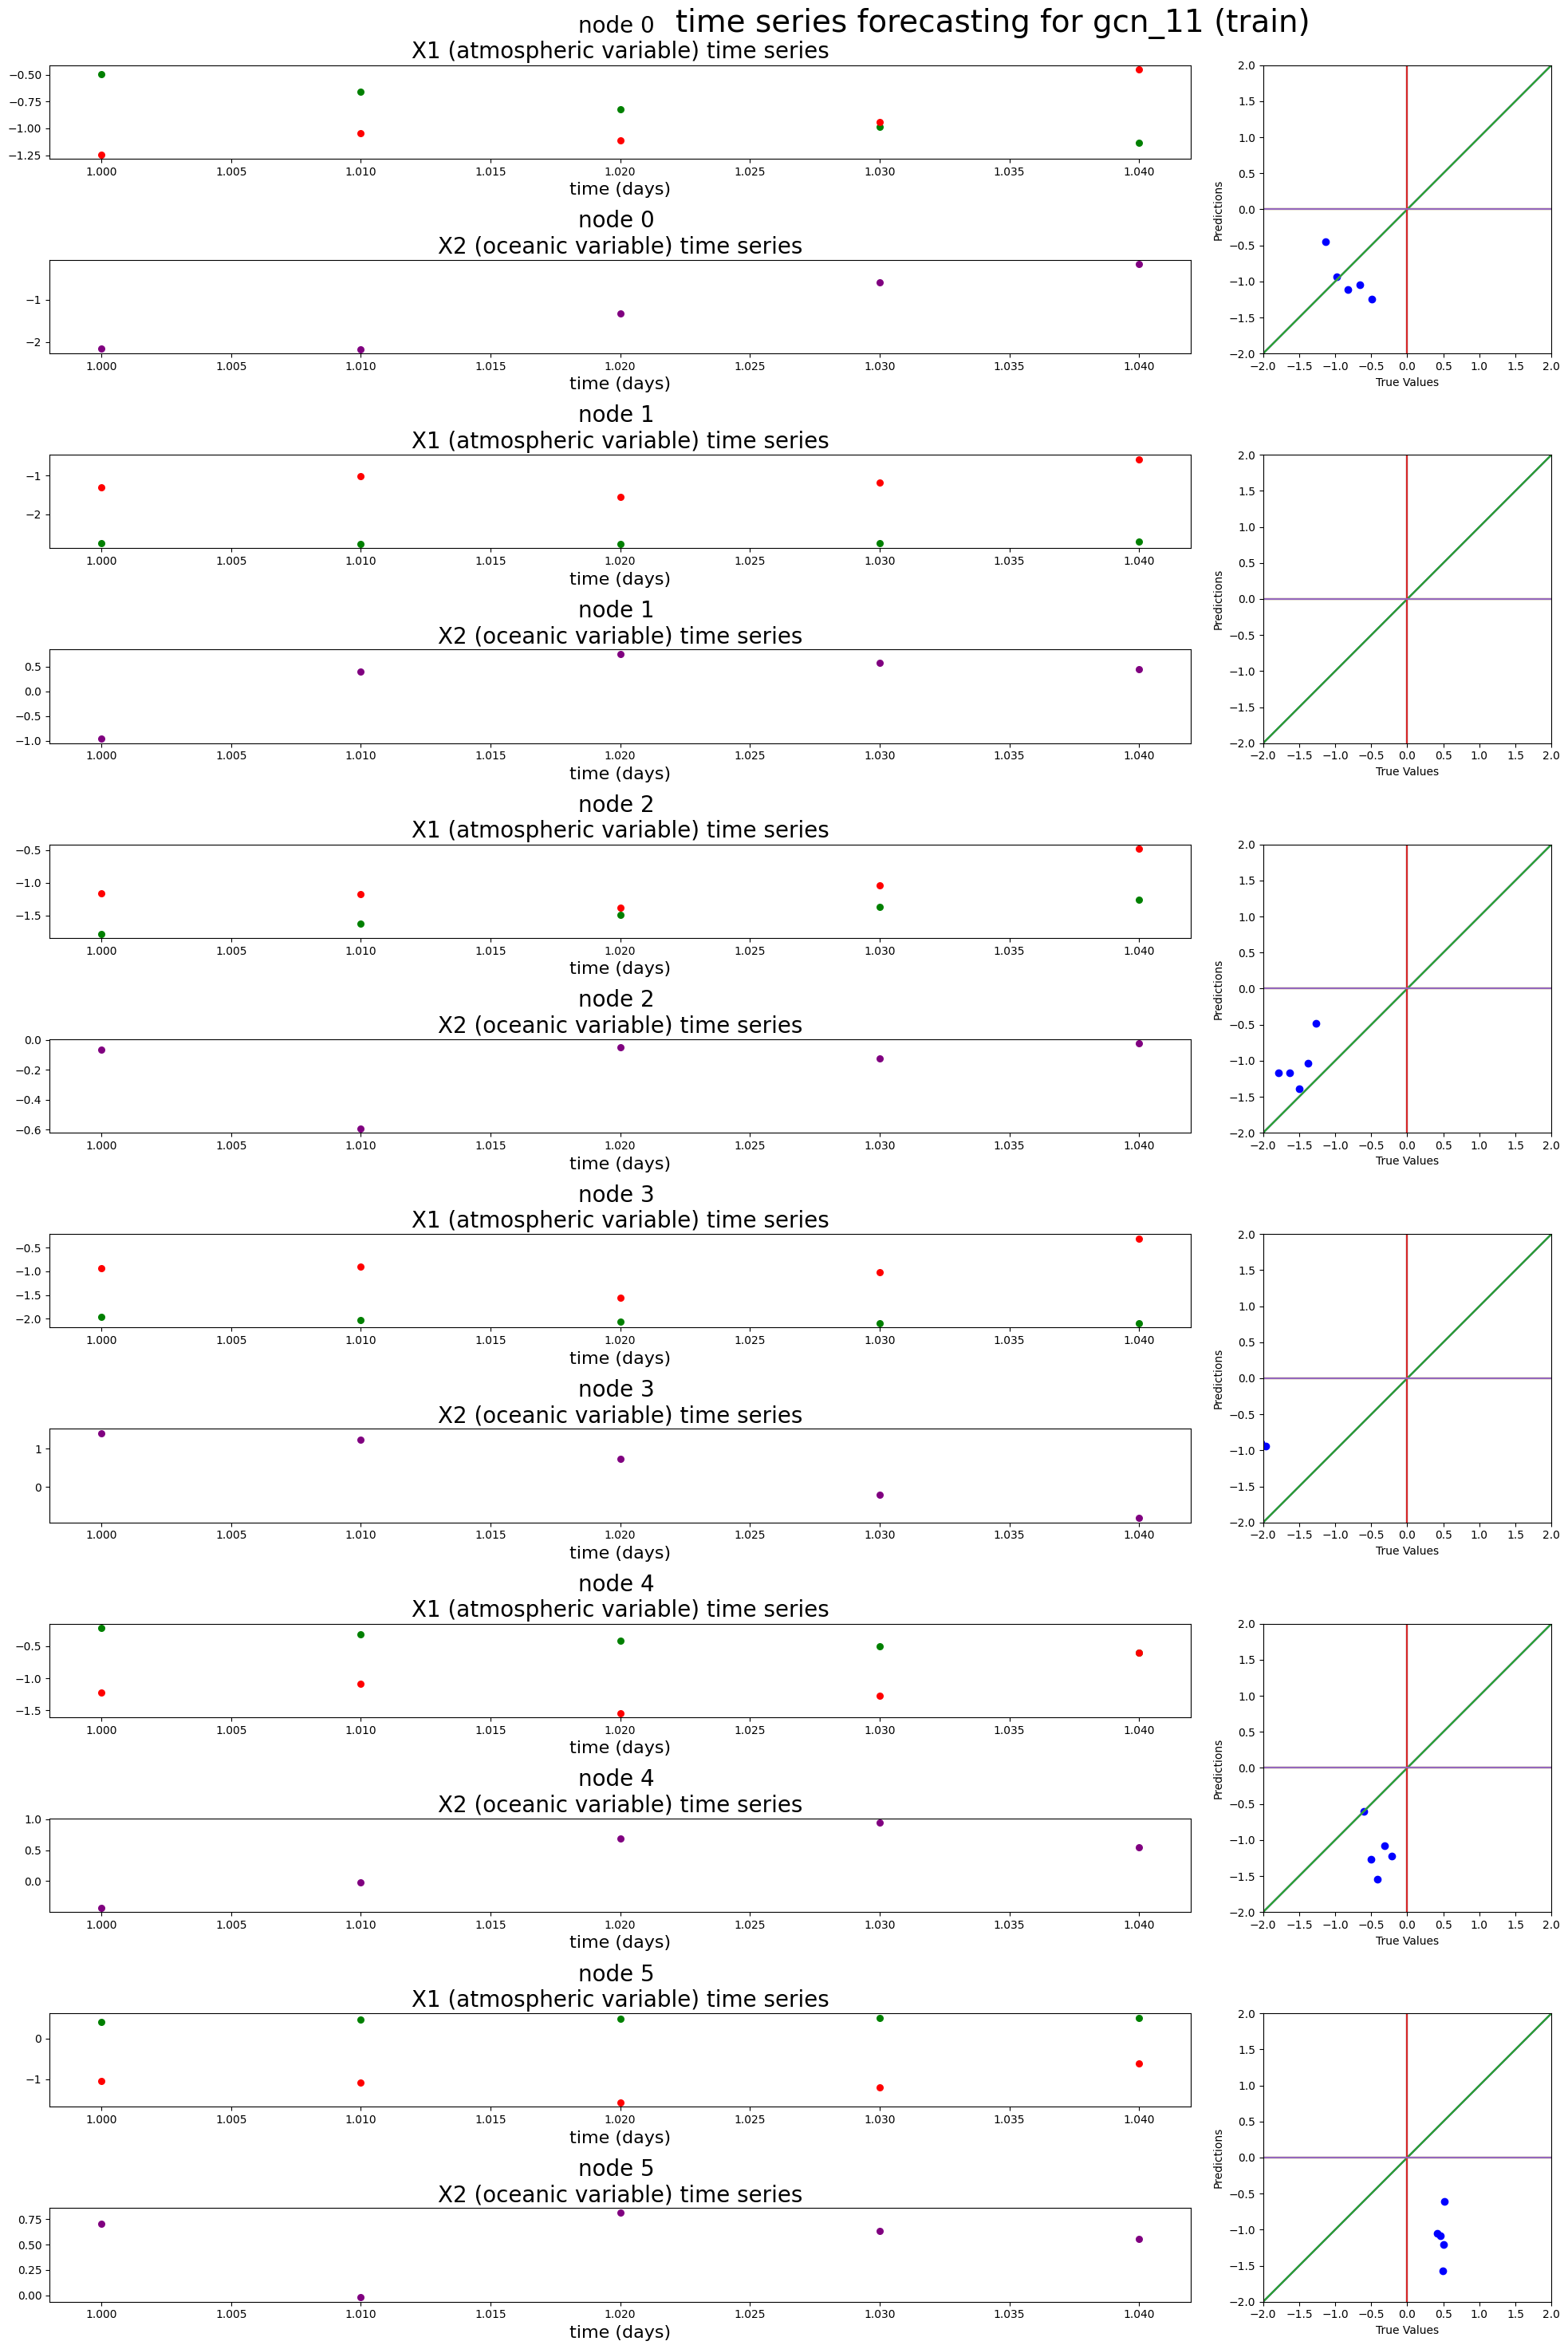

In [168]:
plot_model_results(dataset_5.train,
                   None,
                   GCN_5,
                   history_5,
                   fname_5,
                   nodes=range(6))


okay, doing slightly worse now, which is expected since we have more data. 

how can we check what data each layer/channel of the GCN is using? we should verify that its actually using data from its neighbors. 

I think based on the Lorenz equation it also makes sense to modify the graph adjacency matrix to include connections to the second-next neighbor (i.e. the left 2 (and right 2?) neighbor nodes). 
edit: this notebook now uses datasets with the extra graph connections to 2nd neighbors, which has improved performance marginally. however, the model is still behaving pretty poorly considering we're using 5 data samples. 